# Real or Fake News

### Why should you care about whether your news is real or fake?

- __You deserve the truth.__ You are smart enough to make up your own mind - as long as you have the real facts in front of you. You have every right to be insulted when you are presented with fake news, because you are in essence being treated like an idiot.

- __Fake news destroys your credibility.__ If your arguments are built on bad information, it will be much more difficult for people to believe you now and in the future.

- __Fake news can hurt you, and a lot of other people.__ Purveyors of fake and misleading medical advice like Mercola.com and NaturalNews.com help perpetuate myths like HIV and AIDS aren't related, or that vaccines cause autism. These sites are heavily visited and their lies are dangerous.

- __Real news can benefit you.__ If you want to buy stock in a company, you want to read accurate articles about that company so you can invest wisely.  If you are planning on voting in an election, you want to read as much good information on a candidate so you can vote for the person who best represents your ideas and beliefs. Fake news will not help you make money or make the world a better place, but real news can.

## Importing Libraries

In [96]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
from bs4 import BeautifulSoup
from nltk import pos_tag, ngrams
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [66]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [104]:
import warnings
warnings.filterwarnings('ignore')

## Acquiring Data

In [67]:
columns_list = ['title', 'text', 'subject', 'date']
fake_news = pd.read_csv('Fake.csv', usecols=columns_list)
true_news = pd.read_csv('True.csv', usecols=columns_list)

In [68]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [69]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [70]:
# Creating catogory of news i.e 1 for true and 0 for false.
true_news['category'] = 1
fake_news['category'] = 0
data = pd.concat([fake_news, true_news], ignore_index=True)

In [71]:
print(data.isnull().sum())

title        0
text         0
subject     21
date        21
category     0
dtype: int64


### Basic Data Visualisation

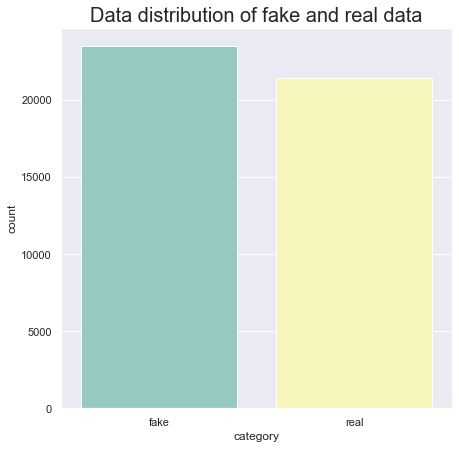

In [168]:
plt.figure(figsize=(7, 7))

sns.set(style="darkgrid")
colour = sns.color_palette("Set3")
ax = sns.countplot(x="category", data=data, palette=colour)
ax.set(xticklabels=['fake', 'real'])

plt.title("Data distribution of fake and real data", size=20)
plt.show()

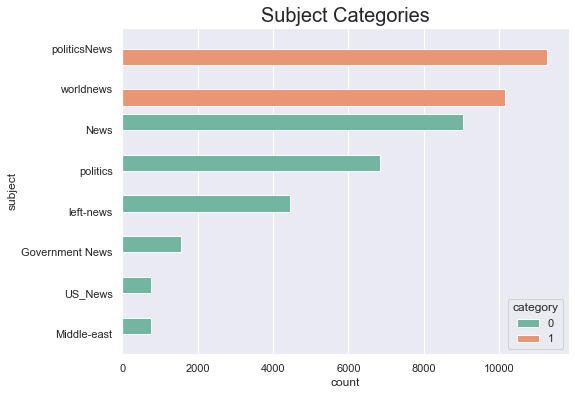

In [73]:
plt.figure(figsize=(8, 6))

sns.set(style="darkgrid")
plt.title('Subject Categories', size=20)

colour = sns.color_palette("Set2")
sns.countplot(y='subject', hue='category', data=data, order=data['subject'].value_counts().iloc[:8].index, palette=colour)
plt.show()

By checking the subject by category plot we can tell subject column is biased towards the classification. So we want to remove it completely.

In [74]:
del data['date']
data['text'] = data['text'] + data['title']
del data['title']
del data['subject']
data.head()

,text,category
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


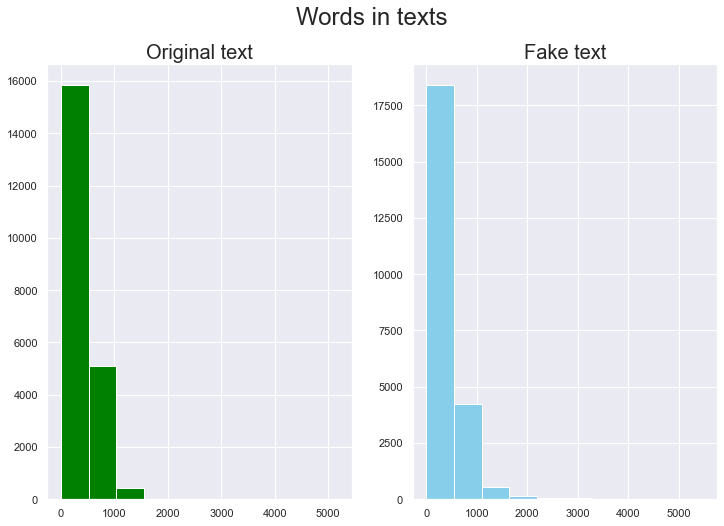

In [75]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=data[data['category']==1].text.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Original text', size=20)

text_len=data[data['category']==0].text.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='skyblue')
ax2.set_title('Fake text', size=20)

fig.suptitle('Words in texts', size=24)
plt.show()

## Data Cleaning

### Stopwords

Stop words are basically a set of commonly used words in any language which does not add much meaning to a sentence i.e. these usually refers to the most common words in a language. For example, the words like the, he, that etc. 

So we can easily remove them from our text by creating list of stopwords, without disturbing the meaning of the actual sentence, which not only makes our model more __robust__ but also efficient in __space__ and __processing time__.

In [76]:
# creating list of stopwords.
stop_list = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop_list.update(punctuations)
stop_list.update(['’', '”', '“'])
print(stop_list)

{'her', 'm', 'been', 'few', '`', 'having', 'yourself', 'but', '&', 'at', 'more', 'hasn', 'own', '/', 'over', 've', 'he', "needn't", '~', 'yourselves', 'again', 'itself', 'be', 'him', 'here', 'mustn', 'nor', 'just', 'are', '[', '^', 'such', 'only', 'they', "should've", 'had', 'off', 'before', "mightn't", 'wouldn', '>', 'needn', '*', 'll', '"', "wasn't", 'weren', 'where', 'does', 'no', 'these', 'then', "that'll", 'for', 'most', 'when', 'why', '=', 'into', 'and', 'your', 'will', 'by', 'not', '“', 'above', 'yours', 'haven', 'too', 'isn', "wouldn't", '{', 'if', 'there', 'herself', 'same', "weren't", '|', 'won', 're', 'about', 'doing', 'both', 'through', "you'd", 'during', 'being', 'do', 'did', ':', ',', 'ours', 'or', '#', '@', 'than', 'an', 'ma', 'in', '(', 'so', 'didn', 'am', 'with', 'because', 'which', 'ain', 'of', "couldn't", 'hers', "hasn't", '.', 'wasn', 'who', 'after', 'hadn', ']', '_', '’', "hadn't", "don't", '\\', 'mightn', 'is', 'the', 'this', '!', 'each', 'from', 'them', "you're",

In [80]:
# Cleaning our data and removing stopwords
def clean_data(text):
    text = text.lower()
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'http\S+', '', text) # remove urls
    text = re.sub('\n', '', text)
    return text

def remove_stopwords(text):
    token_text = word_tokenize(text)
    words = [word for word in token_text if word not in stop_list]
    return ' '.join(words)

In [78]:
print(data.text[0])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [81]:
data['text'] = data['text'].apply(clean_data)
data['text'] = data['text'].apply(remove_stopwords)

In [82]:
print(data.text[0])

donald trump wish americans happy new year leave instead give shout enemies haters dishonest fake news media former reality show star one job country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year president angry pants tweeted great year america country rapidly grows stronger smarter want wish friends supporters enemies haters even dishonest fake news media happy healthy new year great year america donald j. trump realdonaldtrump december tweet went welll expect.what kind president sends new year greeting like despicable petty infantile gibberish trump lack decency even allow rise gutter long enough wish american citizens happy new year bishop talbert swan talbertswan december one likes calvin calvinstowell december impeachment would make great year america also accept regaining control congress miranda yaver mirandayaver december hear talk include many people hate wonder hate alan sandoval december uses 

### Stemming and Lemmatization

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming is a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word. It is typically done by having a look-up table of the lemma forms of words based on their part of speech and returns the base or dictionary form of a word, which is known as the lemma..

Text preprocessing includes both Stemming as well as Lemmatization but Lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

In [159]:
'''
# This function return the part of speech of a word.
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Lemmatization of the Text
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    clean_text = ''
    for w in word_tokenize(text):
        if w.lower() not in stopwords:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text += new_w + ' '
    return clean_text
'''

'''
# Stemming Of the Text
ps = PorterStemmer()
def clean_text(text):
    clean_text = ''
    for w in word_tokenize(text):
        if w.lower() not in stopwords:
            new_w = ps.stem(w)
            clean_text += new_w + ' '
    return clean_text
'''

"\n# Stemming Of the Text\nps = PorterStemmer()\ndef clean_text(text):\n    clean_text = ''\n    for w in word_tokenize(text):\n        if w.lower() not in stopwords:\n            new_w = ps.stem(w)\n            clean_text += new_w + ' '\n    return clean_text\n"

### Data Visualisation

In [84]:
corpus = ' '.join(data.text).split(' ')

def join_words(words):
    return ' '.join(words)

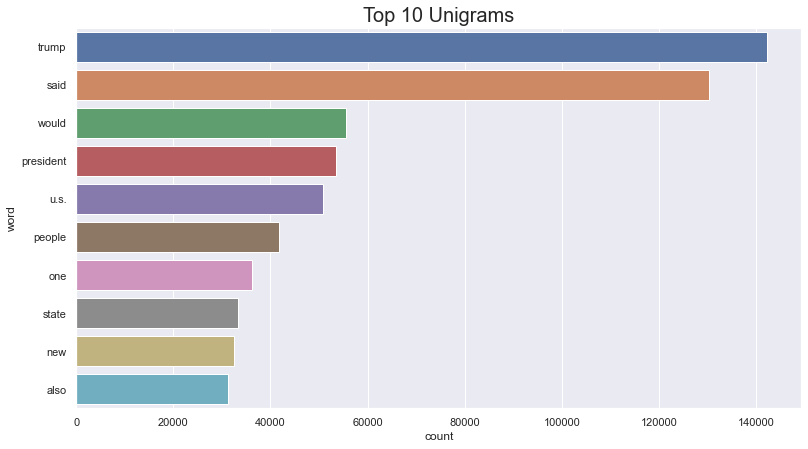

In [85]:
data_unigram = (pd.Series(ngrams(corpus, 1)).value_counts())[:10]
data_unigram_df = pd.DataFrame(data_unigram)
data_unigram_df = data_unigram_df.reset_index()
data_unigram_df = data_unigram_df.rename(columns={"index": "word", 0: "count"})
data_unigram_df['word'] = data_unigram_df['word'].apply(join_words)

plt.figure(figsize = (13,7))
sns.set_style('darkgrid')
sns.barplot(x='count',y='word', data=data_unigram_df)
plt.title('Top 10 Unigrams', size=20)
plt.show()

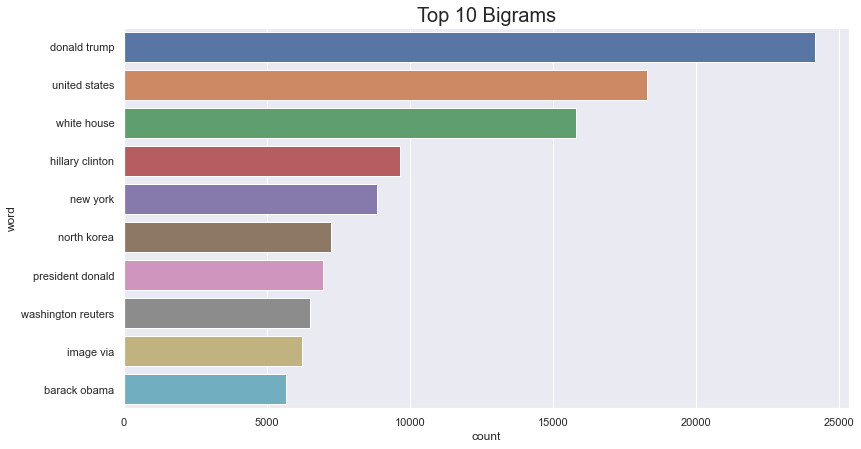

In [87]:
data_bigram = (pd.Series(ngrams(corpus, 2)).value_counts())[:10]
data_bigram_df = pd.DataFrame(data_bigram)
data_bigram_df = data_bigram_df.reset_index()
data_bigram_df = data_bigram_df.rename(columns={"index": "word", 0: "count"})
data_bigram_df['word'] = data_bigram_df['word'].apply(join_words)

plt.figure(figsize = (13,7))
sns.set_style('darkgrid')
sns.barplot(x='count', y='word', data=data_bigram_df)
plt.title('Top 10 Bigrams', size=20)
plt.show()

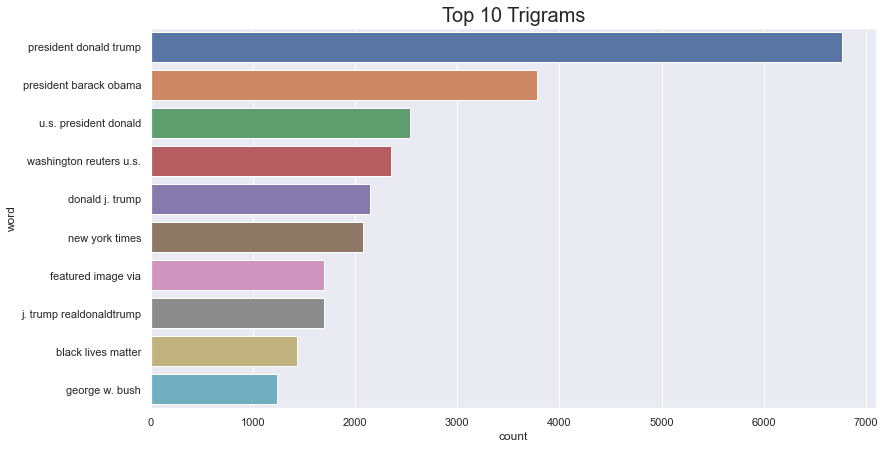

In [88]:
data_trigram = (pd.Series(ngrams(corpus, 3)).value_counts())[:10]
data_trigram_df = pd.DataFrame(data_trigram)
data_trigram_df = data_trigram_df.reset_index()
data_trigram_df = data_trigram_df.rename(columns={"index": "word", 0: "count"})
data_trigram_df['word'] = data_trigram_df['word'].apply(join_words)

plt.figure(figsize = (13,7))
sns.set_style('darkgrid')
sns.barplot(x='count',y='word', data=data_trigram_df)
plt.title('Top 10 Trigrams', size=20)
plt.show()

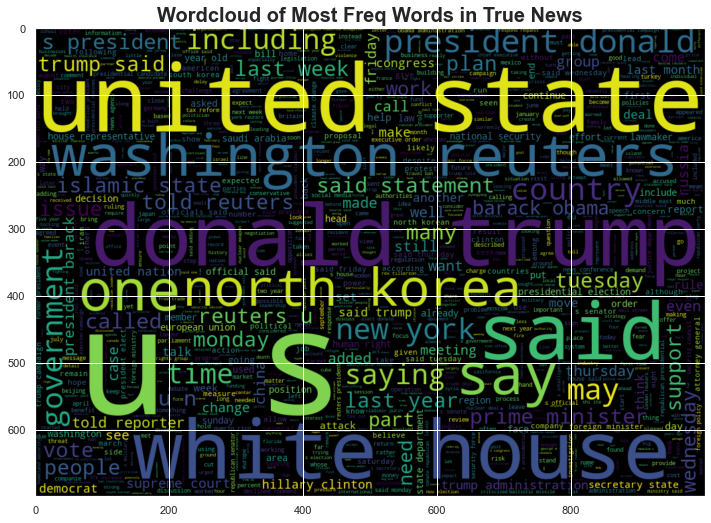

In [91]:
true_corpus = ' '.join(data[data.category==1].text)

plt.figure(figsize = (12,16))
wordcloud = WordCloud(min_font_size = 3,  max_words = 1000 , width = 1000 , height = 700).generate(true_corpus)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Wordcloud of Most Freq Words in True News', size=20, fontweight='bold')
plt.show()

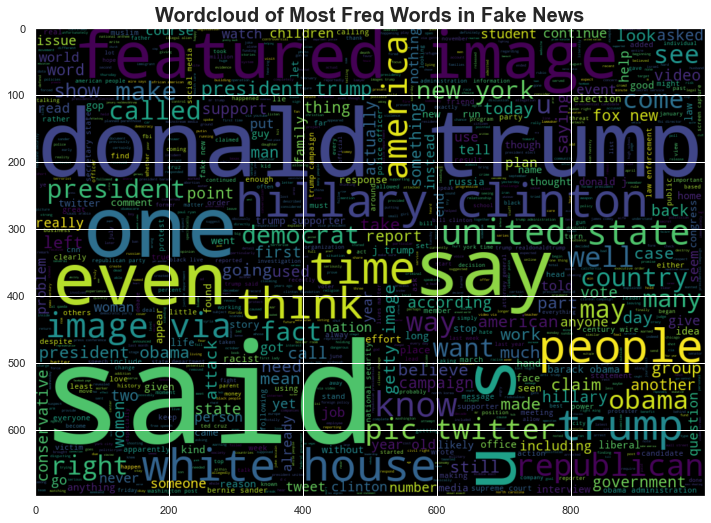

In [90]:
fake_corpus = ' '.join(data[data.category==0].text)

plt.figure(figsize = (12,16))
wordcloud = WordCloud(min_font_size = 3,  max_words = 1000 , width = 1000 , height = 700).generate(fake_corpus)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud of Most Freq Words in Fake News', size=20, fontweight='bold')
plt.show()

### Splitting Data and Model

In [92]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.category, random_state=1, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35935,), (35935,), (8984,), (8984,))

In [105]:
# Creating Models
models = [('Logistic Regression', LogisticRegression(max_iter=500)),('Random Forest', RandomForestClassifier()),
          ('Multinomial NaiveBayes', MultinomialNB()), ('SGD Classifier', SGDClassifier()), ('XGBClassifier', XGBClassifier())]

names = []
results = []
model = []
for name, clf in models:
    pipe = Pipeline([('vect', CountVectorizer(max_features=30000, ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    (name, clf),
                    ])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    
    names.append(name)
    results.append(accuracy)
    model.append(pipe)

[21:14:25] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [108]:
Models = pd.DataFrame({'names':names,
                       'score':results})
Models

,names,score
0,Logistic Regression,0.992654
1,Random Forest,0.998108
2,Multinomial NaiveBayes,0.957035
3,SGD Classifier,0.995659
4,XGBClassifier,0.998664


As we can see even with a simple model we are achieving an accuracy >99%. This tells me dataset is biased, so lets find out what are the factors affecting our data classification.

### Why so high Accuracy

In [109]:
print("\033[1m"'fake article : '"\033[0m", fake_news.text[0])
print('------------------------------------------------------------------------------------------------------------------------------')
print("\033[1m"'true article : '"\033[0m", true_news.text[0])

fake article :  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of d

In [99]:
def count_twitter_mentions(df):
    count = 0
    for text in df['text']:
        count += len(re.findall(re.compile(r'@([A-Za-z0-9_]+)'), text))
    return count

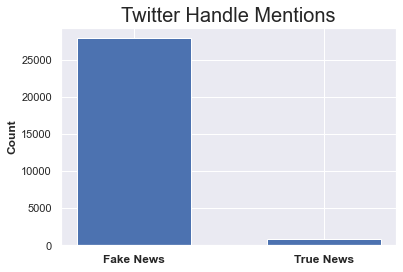

In [100]:
twitter_mentions_fake_data = count_twitter_mentions(fake_news)
twitter_mentions_true_data = count_twitter_mentions(true_news)

plt.figure(figsize=(6, 4))
plt.title('Twitter Handle Mentions', size=20)
plt.bar(x=['Fake News', 'True News'], height=[twitter_mentions_fake_data, twitter_mentions_true_data] ,width=0.6)
plt.ylabel('Count', fontweight='bold', size=12)
plt.xticks(fontweight='bold', size=12)
plt.show()

Lets plot which words have most correlation to category column, which will tell us whether there are any biasing words for classification or not.

In [101]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'])
chi2score = chi2(X, data['category'])

scores = dict(zip(vectorizer.get_feature_names(), chi2score[0]))

counter = Counter(scores)
common = counter.most_common(30)

words = [i[0] for i in common]
chi_scores = [i[1] for i in common]

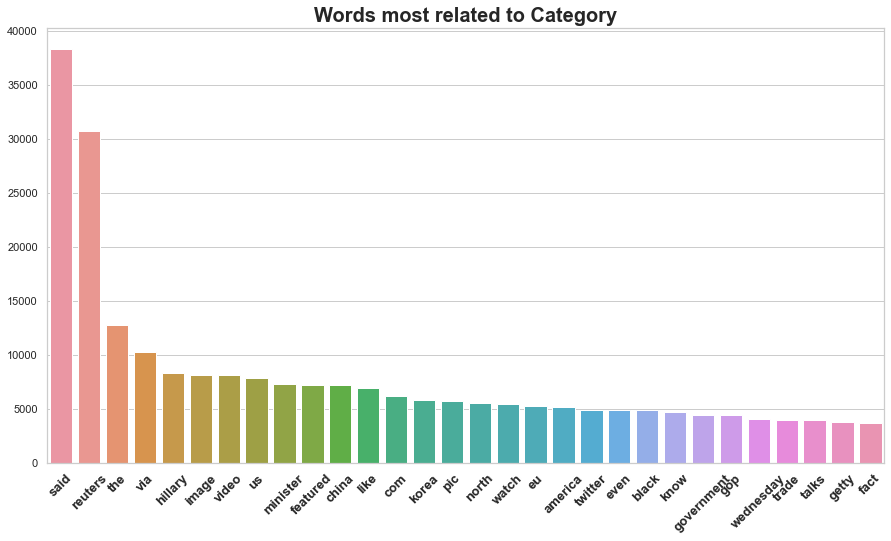

In [102]:
# Top Words on which category is most Dependent
plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.barplot(x=words, y=chi_scores)
plt.title('Words most related to Category', fontweight='bold', size=20)
plt.xticks(rotation=45, fontweight='bold', fontsize=13)
plt.show()

In [157]:
# Checking whether dataset is biased.
result = []
c=0
for text in data['text']:
    if 'reuters' in text:
        result.append(1)
    else:
        result.append(0)

print('Accuracy with word "reuters" only', accuracy_score(data['category'], result))

Accuracy with word "reuters" only 0.9921414100937243


### Conclusion

The dataset has many features that point to bias towards easy classification of news

- The fact that fake news is mixed with twitters points out first biasing factor, generating a dataset that is extremely simple to be able to accept high results without much engineering.

- Resulting in the end the use of a single word can allow almost 100% what is true or false news.

- We can see accuracy with word 'reuters' only reaches 99.2%.